In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, BaggingRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error,median_absolute_error

Los datos del proyecto contienen la siguiente informacion acerca de usuarios de una tarjeta de credito

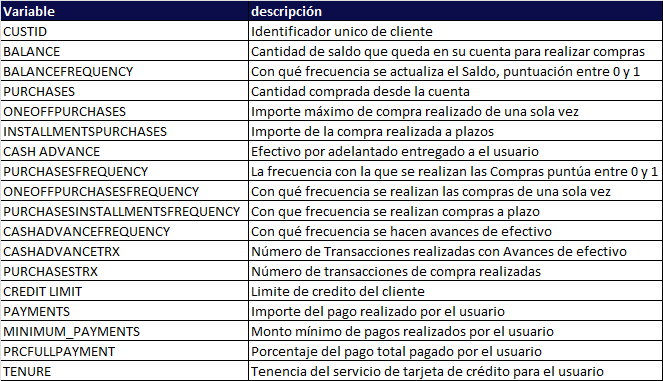

Datos obtenidos en https://www.kaggle.com/datasets/mahnazarjmand/customer-segmentation

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Data science/Machine learning/Regresion/Customer_Data.csv")
df.sample(7)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
1314,C11359,2249.731727,1.0,2598.54,1941.08,657.46,0.000000,1.000000,0.500000,1.0,0.000000,0,31,9000.0,1152.945008,593.311661,0.00,12
5722,C15881,1466.852542,1.0,543.58,543.58,0.00,0.000000,0.250000,0.250000,0.0,0.000000,0,4,2500.0,518.150669,355.284593,0.00,12
6460,C16637,68.007411,1.0,488.66,0.00,488.66,0.000000,1.000000,0.000000,0.9,0.000000,0,19,1500.0,303.387025,143.461021,0.25,10
5285,C15433,1595.980444,1.0,0.00,0.00,0.00,138.761295,0.000000,0.000000,0.0,0.333333,4,0,2400.0,351.305519,440.128449,0.00,12
4780,C14914,1406.483149,1.0,0.00,0.00,0.00,363.680545,0.000000,0.000000,0.0,0.125000,1,0,1500.0,214.423727,362.964840,0.00,8
6494,C16672,2732.813233,1.0,245.01,245.01,0.00,2721.303612,0.166667,0.166667,0.0,0.250000,3,2,5000.0,1289.823661,782.936511,0.00,12
3265,C13359,6209.488896,1.0,0.00,0.00,0.00,3674.314806,0.000000,0.000000,0.0,0.166667,3,0,8500.0,1417.169060,1425.192934,0.00,12


In [4]:
pd.options.display.float_format='{:,.2f}'.format

In [5]:
traduccion = {'CUST_ID':"CLIENTE_ID", 'BALANCE':"SALDO_DISPONIBLE", 'BALANCE_FREQUENCY':"FRECUENCIA_ACTUALIZACION_SALDO", 'PURCHASES':"CANTIDAD_COMPRADA",
       'ONEOFF_PURCHASES':"COMPRAS_UNA_TRANSACCION", 'INSTALLMENTS_PURCHASES':"COMPRAS_PLAZO", 'CASH_ADVANCE':"AVANCES_EFECTIVO",
       'PURCHASES_FREQUENCY':"FRECUENCIAS_COMPRAS", 'ONEOFF_PURCHASES_FREQUENCY':"FRECUENCIA_COMPRAS_UNATRANSACCION",
       'PURCHASES_INSTALLMENTS_FREQUENCY':"FRECUENCIA_COMPRAS_PLAZO", 'CASH_ADVANCE_FREQUENCY':"FRECUENCIA_AVANCES",
       'CASH_ADVANCE_TRX':"CANTIDAD_AVANCES", 'PURCHASES_TRX':"NUMERO_COMPRAS", 'CREDIT_LIMIT':"LIMITE_CREDITO", 'PAYMENTS':"PAGOS",
       'MINIMUM_PAYMENTS':"PAGO_MINIMO", 'PRC_FULL_PAYMENT':"PORCENTAJE_DEUDA_PAGADA", 'TENURE':"TENENCIA"}

In [6]:
df = df.rename(columns=traduccion)

# Limpieza de datos
Realizaremos el proceso de limpieza teniendo en cuenta las situaciones más comunes:

1. Datos faltantes en algunas celdas
2. Columnas irrelevantes (que no responden al problema que queremos resolver)
3. Registros (filas) repetidos
4. Valores extremos (outliers) en el caso de las variables numéricas. Se deben analizar en detalle pues no necesariamente la solución es eliminarlos.


Al final de este proceso de limpieza deberíamos tener un set de datos íntegro, listo para la fase de modelamiento.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CLIENTE_ID                         8950 non-null   object 
 1   SALDO_DISPONIBLE                   8950 non-null   float64
 2   FRECUENCIA_ACTUALIZACION_SALDO     8950 non-null   float64
 3   CANTIDAD_COMPRADA                  8950 non-null   float64
 4   COMPRAS_UNA_TRANSACCION            8950 non-null   float64
 5   COMPRAS_PLAZO                      8950 non-null   float64
 6   AVANCES_EFECTIVO                   8950 non-null   float64
 7   FRECUENCIAS_COMPRAS                8950 non-null   float64
 8   FRECUENCIA_COMPRAS_UNATRANSACCION  8950 non-null   float64
 9   FRECUENCIA_COMPRAS_PLAZO           8950 non-null   float64
 10  FRECUENCIA_AVANCES                 8950 non-null   float64
 11  CANTIDAD_AVANCES                   8950 non-null   int64

Descubrimos que el limite de credito tiene un dato faltante y pago minimo tiene 313 datos faltantes.

In [8]:
df[["LIMITE_CREDITO","PAGO_MINIMO"]].isnull().sum()

LIMITE_CREDITO      1
PAGO_MINIMO       313
dtype: int64

In [9]:
df[df.LIMITE_CREDITO.isnull()]

,CLIENTE_ID,SALDO_DISPONIBLE,FRECUENCIA_ACTUALIZACION_SALDO,CANTIDAD_COMPRADA,COMPRAS_UNA_TRANSACCION,COMPRAS_PLAZO,AVANCES_EFECTIVO,FRECUENCIAS_COMPRAS,FRECUENCIA_COMPRAS_UNATRANSACCION,FRECUENCIA_COMPRAS_PLAZO,FRECUENCIA_AVANCES,CANTIDAD_AVANCES,NUMERO_COMPRAS,LIMITE_CREDITO,PAGOS,PAGO_MINIMO,PORCENTAJE_DEUDA_PAGADA,TENENCIA
5203,C15349,18.40,0.17,0.00,0.00,0.00,186.85,0.00,0.00,0.00,0.17,1,0,NaN,9.04,14.42,0.00,6


In [10]:
df = df.drop(5203)
df = df.reset_index(drop=True)

In [11]:
df[['PAGOS', 'PAGO_MINIMO']][df['PAGO_MINIMO'].isna()].head(10)

,PAGOS,PAGO_MINIMO
3,0.00,NaN
45,0.00,NaN
47,0.00,NaN
54,417.02,NaN
55,0.00,NaN
56,0.00,NaN
63,0.00,NaN
93,0.00,NaN
94,0.00,NaN
97,0.00,NaN


Vamos a mirar donde el pago es menor que el pago minimo, esto casos no tienen sentido pero los conservaremos asi.

In [12]:
e=df[df.PAGOS<df.PAGO_MINIMO]
b=df[df.PAGOS>df.PAGO_MINIMO]
print(f"El numero de casos donde los pagos son menores a el pago minimo son {e.shape[0]} y los casos donde el pago es mayor que el pago minimo son {b.shape[0]}")

El numero de casos donde los pagos son menores a el pago minimo son 2364 y los casos donde el pago es mayor que el pago minimo son 6272


Vamos a rellenar las celdas vacias asi
* si el pago es 0 le asignaremos el valor 0 al pago minimo.
* si la media de pagos es menor que el pago de la celda le asignamos el valor del pago
* si el valor de la media es mayor que el pago le asiganamos la media de pagos


In [13]:
condicion = df.PAGOS == 0
df.loc[condicion, 'PAGO_MINIMO'] = 0

df.PAGO_MINIMO = np.where(df.PAGO_MINIMO.isnull and (np.mean(df.PAGOS) < df.PAGOS),df.PAGOS,df.PAGO_MINIMO)
df.PAGO_MINIMO = np.where(df.PAGO_MINIMO.isnull and (np.mean(df.PAGOS) > df.PAGOS),np.mean(df.PAGOS),df.PAGO_MINIMO)

Nos aseguramos de no tener datos nulos.

In [14]:
df.isnull().sum()

CLIENTE_ID                           0
SALDO_DISPONIBLE                     0
FRECUENCIA_ACTUALIZACION_SALDO       0
CANTIDAD_COMPRADA                    0
COMPRAS_UNA_TRANSACCION              0
COMPRAS_PLAZO                        0
AVANCES_EFECTIVO                     0
FRECUENCIAS_COMPRAS                  0
FRECUENCIA_COMPRAS_UNATRANSACCION    0
FRECUENCIA_COMPRAS_PLAZO             0
FRECUENCIA_AVANCES                   0
CANTIDAD_AVANCES                     0
NUMERO_COMPRAS                       0
LIMITE_CREDITO                       0
PAGOS                                0
PAGO_MINIMO                          0
PORCENTAJE_DEUDA_PAGADA              0
TENENCIA                             0
dtype: int64

Eliminacion de variables columnas inecesarias
La variable CLIENTE_ID no es necesaria para nuestra analisis por tal motivo la vamos a eliminar

Ne tenemos variables No numericas por lo que solo debemos analizar que la desviacion estandas de cada columna se diferente de 0 para determinar que la columna tiene mas de un valor.

In [15]:
df.drop("CLIENTE_ID",axis=1,inplace=True)

In [16]:
df.std()

SALDO_DISPONIBLE                    2,081.58
FRECUENCIA_ACTUALIZACION_SALDO          0.24
CANTIDAD_COMPRADA                   2,136.73
COMPRAS_UNA_TRANSACCION             1,659.97
COMPRAS_PLAZO                         904.38
AVANCES_EFECTIVO                    2,097.26
FRECUENCIAS_COMPRAS                     0.40
FRECUENCIA_COMPRAS_UNATRANSACCION       0.30
FRECUENCIA_COMPRAS_PLAZO                0.40
FRECUENCIA_AVANCES                      0.20
CANTIDAD_AVANCES                        6.82
NUMERO_COMPRAS                         24.86
LIMITE_CREDITO                      3,638.82
PAGOS                               2,895.17
PAGO_MINIMO                         2,606.32
PORCENTAJE_DEUDA_PAGADA                 0.29
TENENCIA                                1.34
dtype: float64

Ninguna desviacion estandar es 0 por lo que conservamos todas las columnas.

# Eliminacion de filas repetidas

In [17]:
print(f'Tamaño del set antes de eliminar las filas repetidas: {df.shape}')
df.drop_duplicates(inplace=True)
print(f'Tamaño del set después de eliminar las filas repetidas: {df.shape}')

Tamaño del set antes de eliminar las filas repetidas: (8949, 17)
Tamaño del set después de eliminar las filas repetidas: (8949, 17)


# Manejo de valores atipicos

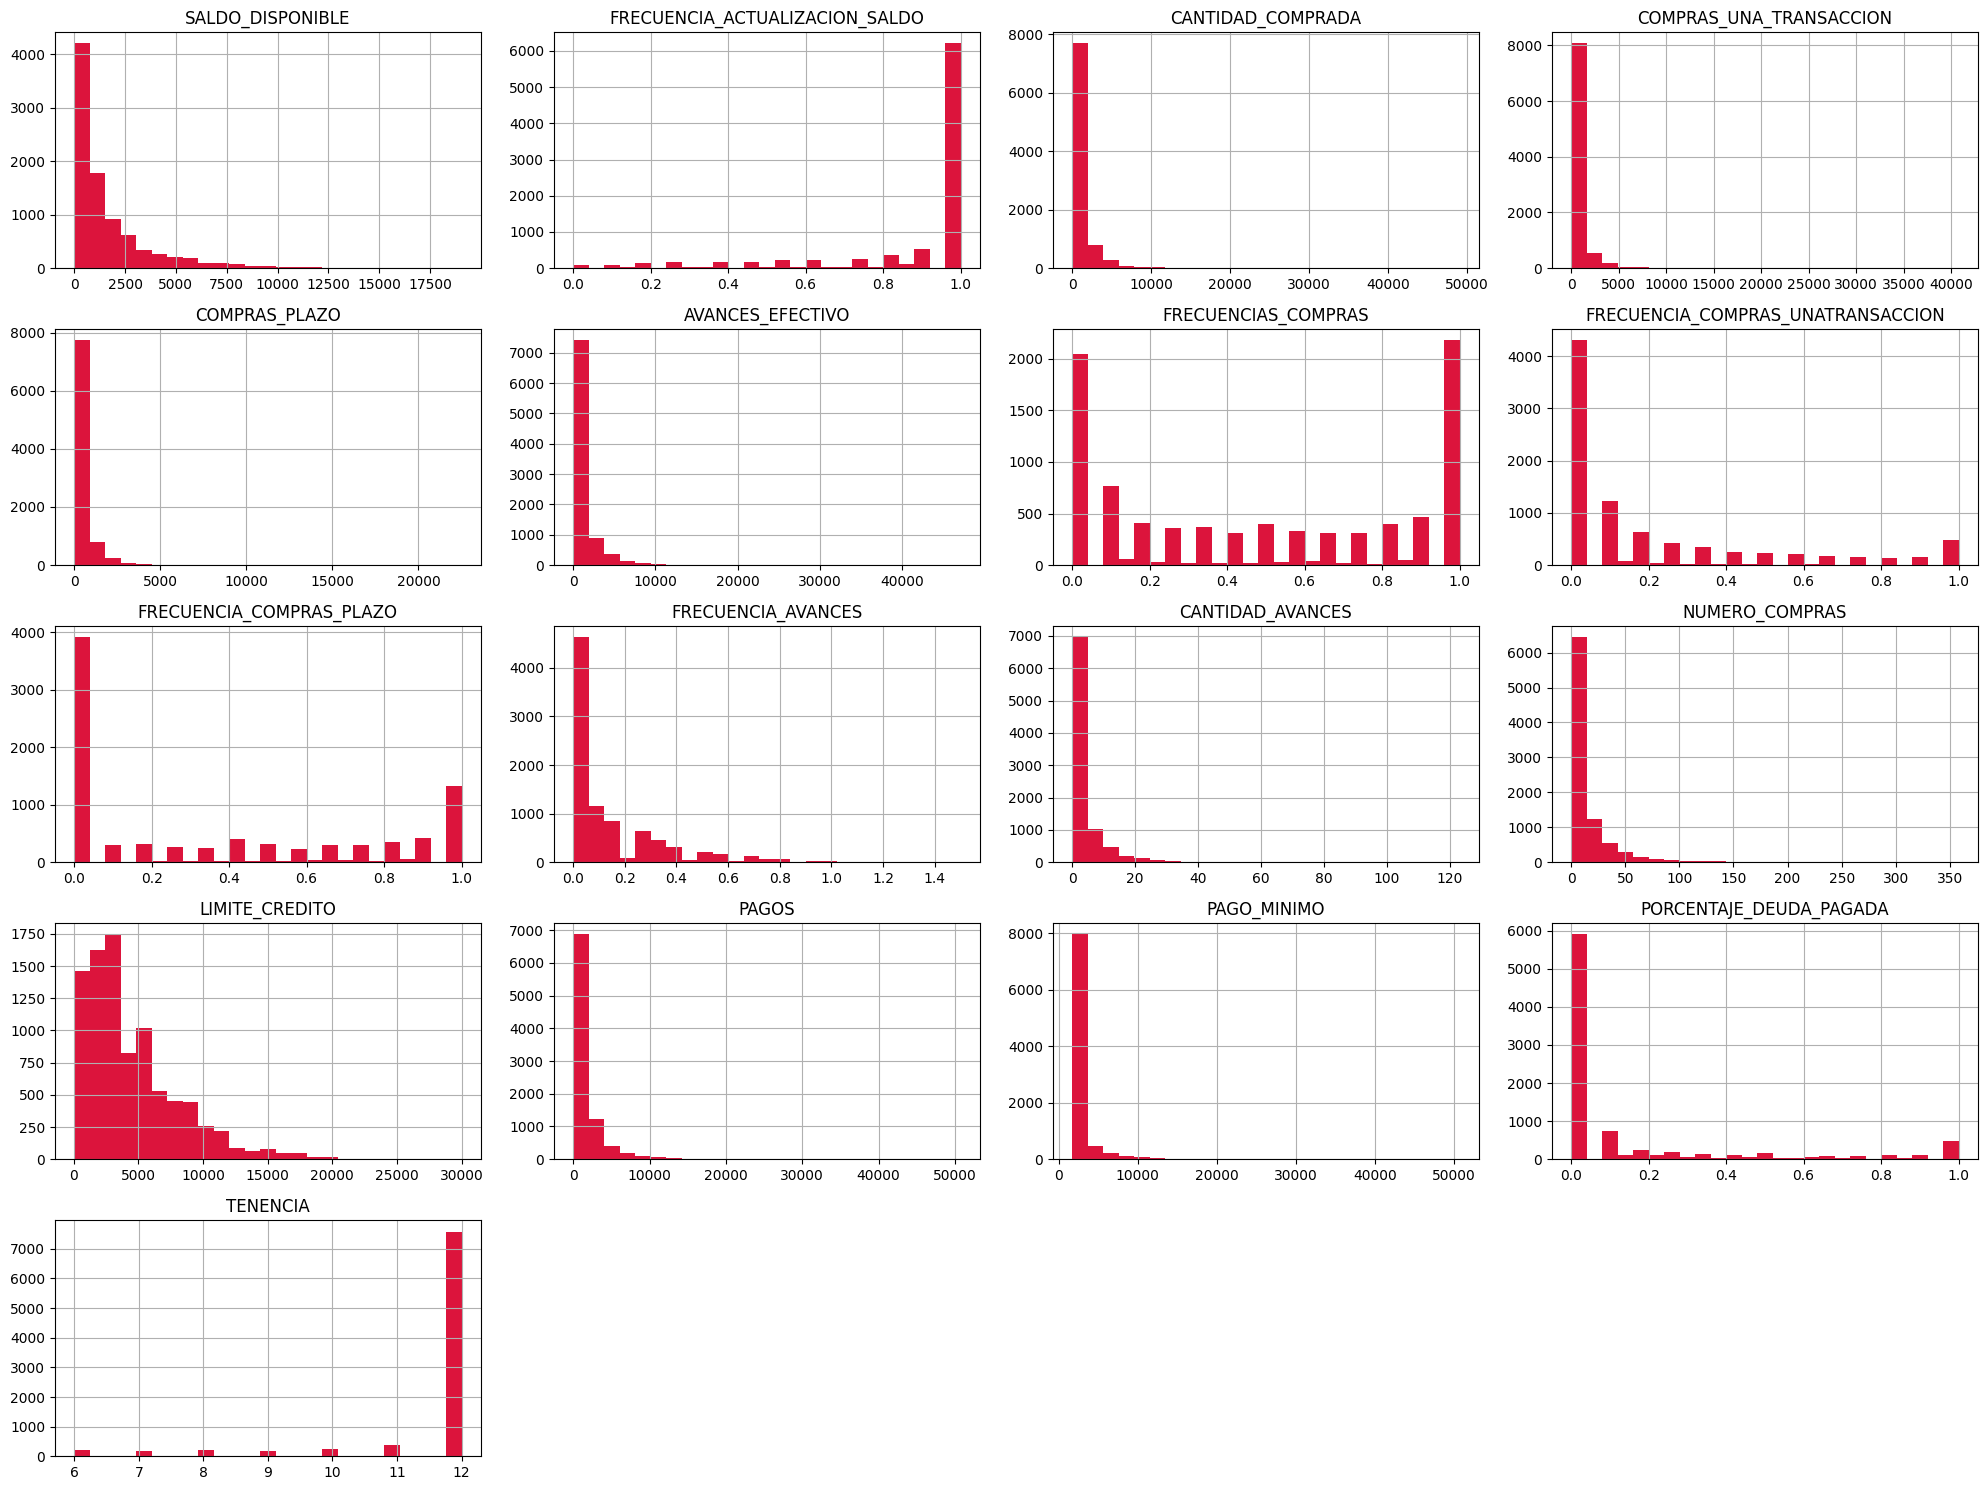

In [18]:
df.hist(bins=25 ,figsize=(20,15), color = 'crimson')

plt.tight_layout()
plt.show()

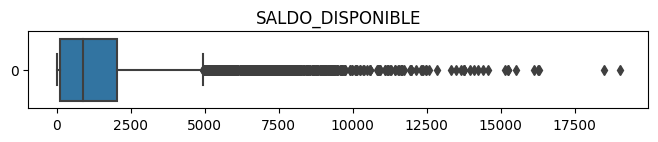

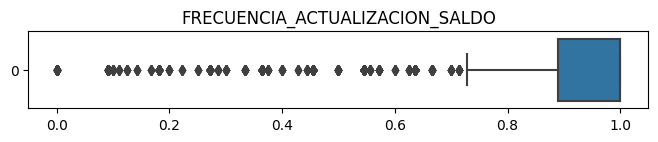

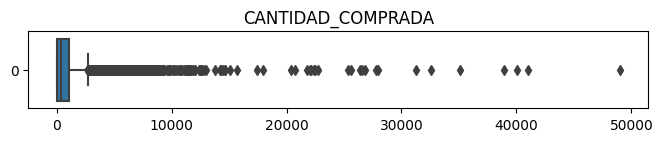

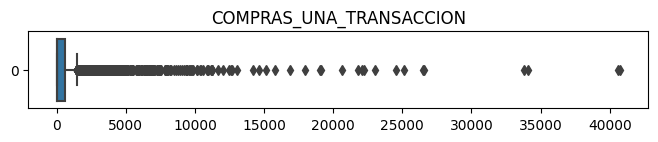

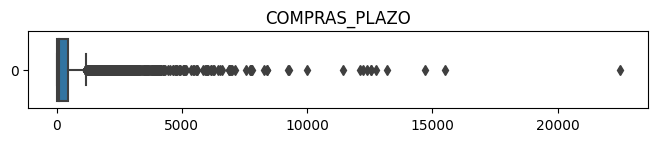

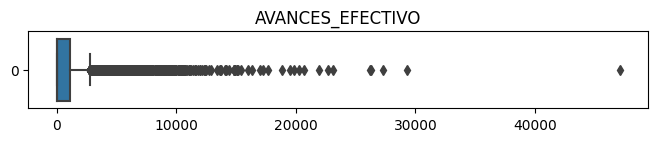

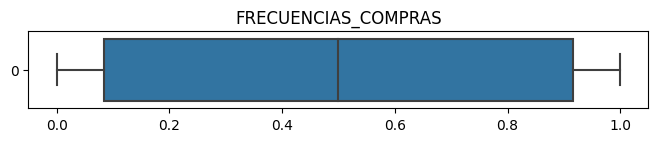

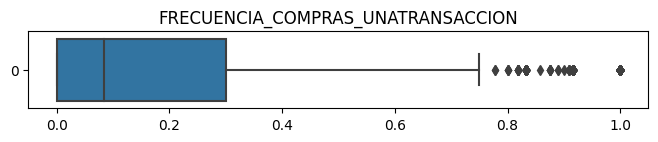

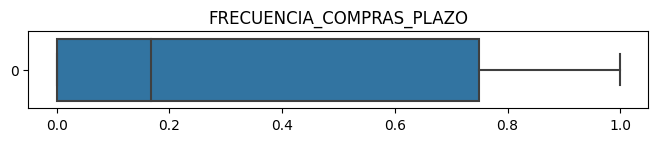

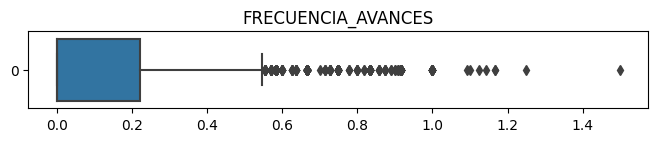

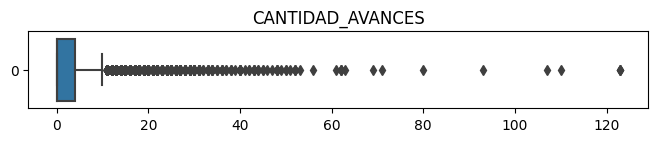

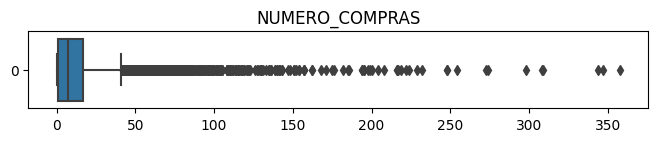

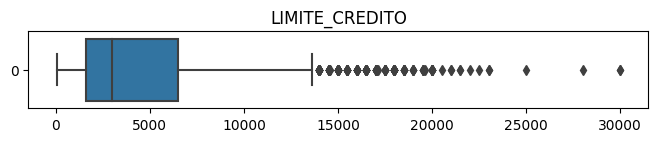

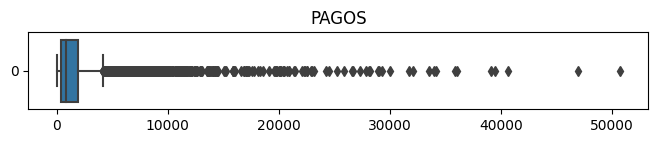

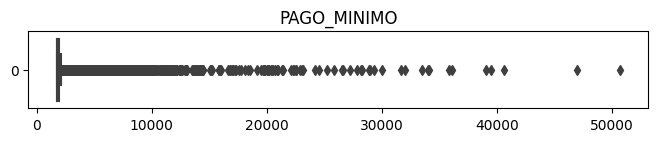

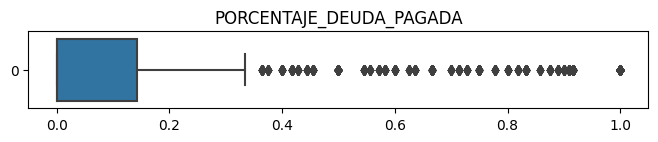

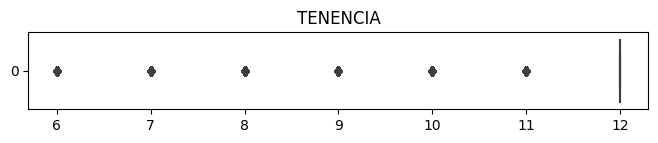

In [19]:
for i in range (len(df.columns)):
    fig= plt.subplots( figsize=(8,1))
    plt.subplot()
    ax=  sns.boxplot(df[df.columns[i]], orient='h')
    plt.title(df.columns[i])

Los valores atipicos tienen sentido en el contexto en el que estamos, por tal motivo se decide conservarlos.

# Division De Datos

El objetivo del analisis es predecir el limite de credito del cliente, esto con el fin de saber si dependiendo de su comportamiento se le debe aumentar o disminuir el cupo de credito.

In [20]:
X = df.drop("LIMITE_CREDITO", axis=1)
y= df["LIMITE_CREDITO"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"la longitud de X es {X_train.shape} y la longitud de y {y_train.shape}")

la longitud de X es (6264, 16) y la longitud de y (6264,)


# Escalamiento de los datos

En este paso del proceso transformaremos nuestros datos para que se encuentre entre 0 y 1. Usando el algoritmo MinMax el cual identifica el valor mayor y le asigna el valor 1 y el valor menor le asigna el valor 0. el resto de los datos se tranforman usando operaciones aritmeticas

In [21]:
escalador_x = preprocessing.MinMaxScaler()
escalador_y = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(escalador_x.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(escalador_x.transform(X_test), columns=X_test.columns)
y_train=escalador_y.fit_transform(y_train.values.reshape(-1,1))
y_test = escalador_y.transform(y_test.values.reshape(-1,1))
X_train.head(5)

,SALDO_DISPONIBLE,FRECUENCIA_ACTUALIZACION_SALDO,CANTIDAD_COMPRADA,COMPRAS_UNA_TRANSACCION,COMPRAS_PLAZO,AVANCES_EFECTIVO,FRECUENCIAS_COMPRAS,FRECUENCIA_COMPRAS_UNATRANSACCION,FRECUENCIA_COMPRAS_PLAZO,FRECUENCIA_AVANCES,CANTIDAD_AVANCES,NUMERO_COMPRAS,PAGOS,PAGO_MINIMO,PORCENTAJE_DEUDA_PAGADA,TENENCIA
0,0.11,1.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.36,0.19,0.00,0.31,0.28,0.30,1.00
1,0.00,0.27,0.01,0.00,0.02,0.00,0.25,0.00,0.17,0.00,0.00,0.02,0.00,0.00,0.08,1.00
2,0.00,0.82,0.00,0.00,0.01,0.00,0.75,0.00,0.67,0.00,0.00,0.03,0.00,0.00,1.00,1.00
3,0.07,1.00,0.02,0.00,0.04,0.03,0.58,0.08,0.42,0.36,0.07,0.02,0.06,0.02,0.09,1.00
4,0.03,0.64,0.03,0.03,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.01,0.00,0.00,0.00,1.00


Vamos a escalar los datos sin dividirlos en test de entrenamiento y prueba para la validacion cruzada

In [22]:
X_escalado = pd.DataFrame(escalador_x.fit_transform(X), columns=X.columns)
y_escalado=escalador_y.fit_transform(y.values.reshape(-1,1))

# Modelado

Como la variable que queremos predecir es una variable continua nustro problema es un problema de regresion. Vamos a usar modelos supervisados, mas especificamente los adaptados a la regresion de la libreria de scikit-learn



In [23]:
#Este diccionario almacenara el rendimiento de cada uno de los modelos que se estaran provando
rendimiento={}

## KNN

Para entrenar los modelo de KNN es necesario encontrar cual es el k que nos brinda el mejor rendimieto. El primer paso sera encontrar ese valor de K.

In [24]:
Ks=[]
errores_cuadraticos_medios =[]

for i in range(1,100):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train,y_train)

  y_pred = knn.predict(X_test)
  ecm = mean_squared_error(y_test, y_pred)

  Ks.append(i)
  errores_cuadraticos_medios.append(ecm)

Text(0.5, 1.0, 'Rendimiento del modelo por cada k')

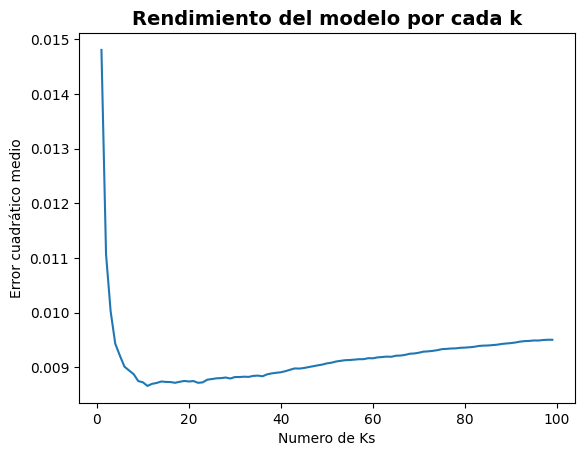

In [25]:
fig, ax = plt.subplots()
ax.plot(Ks,errores_cuadraticos_medios)

plt.ylabel('Error cuadrático medio')
plt.xlabel('Numero de Ks')
plt.title('Rendimiento del modelo por cada k',fontdict = {'fontsize':14, 'fontweight':'bold'})

In [26]:
#vamos a buscar el numero mas pequeño en la lista errores_cuadraticos_medios
numero_pequeño = 100
pocision = 0 #La pocision donde se encuentra el numero mas pequeño
for i in range(0,len(errores_cuadraticos_medios)):
  if errores_cuadraticos_medios[i] < numero_pequeño:
    numero_pequeño = errores_cuadraticos_medios[i]
    pocision = i

print(f"El error cuadratico medio mas pequeño es {numero_pequeño} pertenciente al k numero {Ks[pocision]}")

El error cuadratico medio mas pequeño es 0.008658713713085837 pertenciente al k numero 11


# Busqueda por cuadricula
Usaremos la busqueda por cuadricula para mejorar el rendimiento del modelo.

In [27]:
knn=KNeighborsRegressor(n_neighbors=Ks[pocision])
knn_param={'weights':['uniform','distance'],"p":[1,2]}

grid_search = GridSearchCV(knn,knn_param , cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_escalado, y_escalado)


GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_neighbors=11),
             param_grid={'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [28]:
grid_search.best_params_

{'p': 2, 'weights': 'uniform'}

In [29]:
knn = KNeighborsRegressor(n_neighbors=Ks[pocision],p=2,weights='uniform')
print(f'Se entreno con k = {Ks[pocision]}')
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

ecm = mean_squared_error(y_test, y_pred)
ecm = escalador_y.inverse_transform(ecm.reshape(-1,1))[0][0]
eam = median_absolute_error(y_test,y_pred)
eam = escalador_y.inverse_transform(eam.reshape(-1,1))[0][0]
error = np.sqrt(ecm)

print("Error cuadrático medio (MSE):", ecm)
print("Error absoluto medio (MAE):", eam)
print("El error es ", error)

rendimiento["KNN"]=error

Se entreno con k = 11
Error cuadrático medio (MSE): 309.3284757069208
Error absoluto medio (MAE): 1445.5687528551853
El error es  17.587736514597914


Validacion cruzada

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(knn, X_escalado, y_escalado, cv=kf, scoring="neg_mean_squared_error")

scores_final = list(map(lambda x:escalador_y.inverse_transform(x.reshape(-1,1))[0][0]*-1,scores))

print("Scores de validación cruzada:", scores_final)
print("error cuadratico medio:", np.mean(scores_final))
print("El error promedio es: ",np.sqrt( np.mean(scores_final)))

Scores de validación cruzada: [206.46214903937712, 237.86086217296653, 230.71800455145546, 223.0799877861208, 197.65620172244775]
error cuadratico medio: 219.15544105447353
El error promedio es:  14.803899521898733


## Arbol de decision

Para tener un buen modelo de arbol de decision es importante evitar el sobre ajusta, para esto vamos a buscar la profundidad que minimize los errores del modelo.

In [31]:
profundidades = []
ecms = []

for i in range(0,21):
  if i==0:
    arbol_regresor = DecisionTreeRegressor()
    arbol_regresor.fit(X_train,y_train)

    y_pred = arbol_regresor.predict(X_test)

    ecm = mean_squared_error(y_test, y_pred)

    ecms.append(ecm)
    profundidades.append(i)

  else:
    arbol_regresor = DecisionTreeRegressor(max_depth=i)
    arbol_regresor.fit(X_train,y_train)

    y_pred = arbol_regresor.predict(X_test)

    ecm = mean_squared_error(y_test, y_pred)

    ecms.append(ecm)
    profundidades.append(i)


Text(0.5, 1.0, 'Rendimiento del modelo por cada nivel de profundidad')

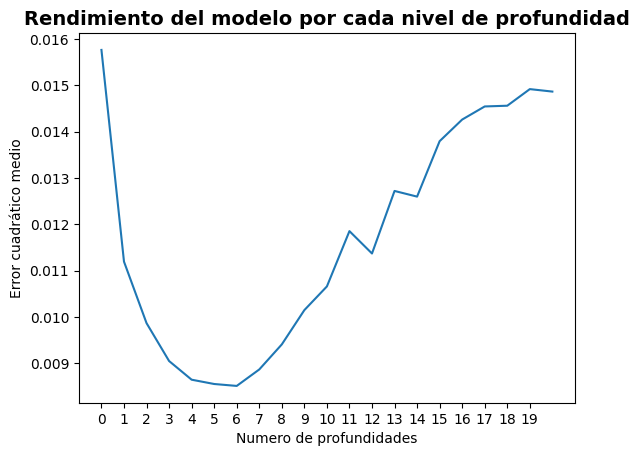

In [32]:
fig, ax = plt.subplots()
ax.plot(profundidades,ecms)
ax.set_xticks(range(0, 20))

plt.ylabel('Error cuadrático medio')
plt.xlabel('Numero de profundidades')
plt.title('Rendimiento del modelo por cada nivel de profundidad',fontdict = {'fontsize':14, 'fontweight':'bold'})

In [33]:
#vamos a buscar el numero mas pequeño en la lista errores_cuadraticos_medios
numero_pequeño = 100000
pocision = 0 #La pocision donde se encuentra el numero mas pequeño
for i in range(0,len(ecms)):
  if ecms[i] < numero_pequeño:
    numero_pequeño = ecms[i]
    pocision = i

print(f"El error cuadratico medio mas pequeño es {numero_pequeño} pertenciente a la profundidad numero {profundidades[pocision]}")

El error cuadratico medio mas pequeño es 0.008513686854501042 pertenciente a la profundidad numero 6


In [36]:
arbol_regresor = DecisionTreeRegressor(max_depth=profundidades[pocision], min_samples_leaf=4)
print(f"Estamos usando un maximo de profundidad de {profundidades[pocision]}")
arbol_regresor.fit(X_train,y_train)

y_pred = arbol_regresor.predict(X_test)

ecm = mean_squared_error(y_test, y_pred)
ecm = escalador_y.inverse_transform(ecm.reshape(-1,1))[0][0]
eam = median_absolute_error(y_test,y_pred)
eam = escalador_y.inverse_transform(eam.reshape(-1,1))[0][0]
error = np.sqrt(ecm)

print("Error cuadrático medio (MSE):", ecm)
print("Error absoluto medio (MAE):", eam)
print("El error es ", error)

rendimiento["Arbol Decision"]=error

Estamos usando un maximo de profundidad de 6
Error cuadrático medio (MSE): 310.3086455920621
Error absoluto medio (MAE): 1599.8681470271486
El error es  17.615579626911572


In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(arbol_regresor, X_escalado, y_escalado, cv=kf, scoring="neg_mean_squared_error")

scores_final = list(map(lambda x:escalador_y.inverse_transform(x.reshape(-1,1))[0][0]*-1,scores))

print("Scores de validación cruzada:", scores_final)
print("error cuadratico medio:", np.mean(scores_final))
print("El error promedio es: ",np.sqrt( np.mean(scores_final)))

Scores de validación cruzada: [213.31155503904802, 212.20143324806443, 235.39502225698052, 204.05269109239353, 190.8788263195601]
error cuadratico medio: 211.16790559120932
El error promedio es:  14.531617445804487


# Metodos ensemble
Vamos a usar diferentes tecnicas de aprendizaje en conjunto para mejorar aun mas nuestro modelo.

## Bosques aleatorios

Los bosques aleatorios al tratarse de un metodo ensemble o en conjunto de los arboles de decision tambien debemos hallarle el nivel de profundidad optimo.

In [38]:
profundidades = []
ecms_bosque = []

for i in range(0,21):
  if i==0:
    bosque_regresor =  RandomForestRegressor(n_estimators=100,min_samples_split=2,random_state=1)
    bosque_regresor.fit(X_train,np.ravel(y_train))

    y_pred = bosque_regresor.predict(X_test)

    ecm = mean_squared_error(y_test, y_pred)

    ecms_bosque.append(ecm)
    profundidades.append(i)

  else:
    bosque_regresor =  RandomForestRegressor(n_estimators=100,max_depth=i,min_samples_split=2,random_state=1)
    bosque_regresor.fit(X_train,np.ravel(y_train))

    y_pred = bosque_regresor.predict(X_test)

    ecm = mean_squared_error(y_test, y_pred)

    ecms_bosque.append(ecm)
    profundidades.append(i)


Text(0.5, 1.0, 'Rendimiento del modelo por cada nivel de profundidad')

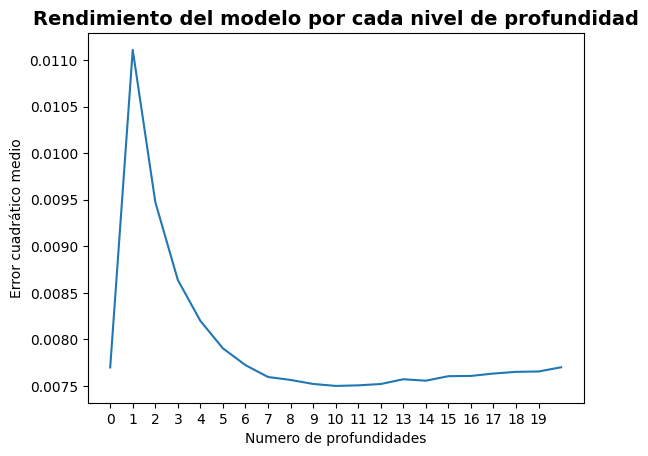

In [39]:
fig, ax = plt.subplots()
ax.plot(profundidades,ecms_bosque)
ax.set_xticks(range(0, 20))

plt.ylabel('Error cuadrático medio')
plt.xlabel('Numero de profundidades')
plt.title('Rendimiento del modelo por cada nivel de profundidad',fontdict = {'fontsize':14, 'fontweight':'bold'})

In [40]:
#vamos a buscar el numero mas pequeño en la lista errores_cuadraticos_medios
numero_pequeño = 100000
pocision = 0 #La pocision donde se encuentra el numero mas pequeño
for i in range(0,len(ecms_bosque)):
  if ecms_bosque[i] < numero_pequeño:
    numero_pequeño = ecms_bosque[i]
    pocision = i

print(f"El error cuadratico medio mas pequeño es {numero_pequeño} pertenciente a la profundidad numero {profundidades[pocision]}")

El error cuadratico medio mas pequeño es 0.007500985865367634 pertenciente a la profundidad numero 10


In [41]:
print(ecms_bosque)

[0.007699383155137036, 0.011108174937084513, 0.00947592765980622, 0.008638396211512762, 0.00819896313286045, 0.007904250557228175, 0.007724240689125393, 0.007596821228602284, 0.007565082057055287, 0.007522279876695981, 0.007500985865367634, 0.007507028592369498, 0.007521523253153331, 0.007572547678095429, 0.007557287300097214, 0.00760553743154952, 0.007608097771269025, 0.007633922062278708, 0.007652007227450116, 0.007655976802294416, 0.007701162053579133]


In [42]:
bosque_aleatorio = RandomForestRegressor(n_estimators=100,max_depth=profundidades[pocision],min_samples_split=2,random_state=1)
print(f"Se entreno el modelo con {profundidades[pocision]} profundidades")

Se entreno el modelo con 10 profundidades


In [43]:
bosque_aleatorio.fit(X_train,np.ravel(y_train))

y_pred = bosque_aleatorio.predict(X_test)

ecm = mean_squared_error(y_test, y_pred)
ecm = escalador_y.inverse_transform(ecm.reshape(-1,1))[0][0]
eam = median_absolute_error(y_test,y_pred)
eam = escalador_y.inverse_transform(eam.reshape(-1,1))[0][0]
error = np.sqrt(ecm)

print("Error cuadrático medio (MSE):", ecm)
print("Error absoluto medio (MAE):", eam)
print("El error es ", error)

rendimiento["Bosque Aleatorio"]=error

Error cuadrático medio (MSE): 274.6545266677606
Error absoluto medio (MAE): 1419.811415149453
El error es  16.572704265380487


In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(bosque_aleatorio, X_escalado, np.ravel(y_escalado), cv=kf, scoring="neg_mean_squared_error")

scores_final = list(map(lambda x:escalador_y.inverse_transform(x.reshape(-1,1))[0][0]*-1,scores))

print("Scores de validación cruzada:", scores_final)
print("error cuadratico medio:", np.mean(scores_final))
print("El error promedio es: ",np.sqrt( np.mean(scores_final)))

Scores de validación cruzada: [183.41926777712072, 185.06185482665182, 196.6537467770354, 178.59218659651594, 160.5312093494104]
error cuadratico medio: 180.85165306534685
El error promedio es:  13.448109646539429


# Regresion por votacion

para este caso vamos a usar el metodo de ensambre VotingRegresor de sklearn

In [45]:
regresion_votacion = VotingRegressor([('KNN', knn), ('Arbol_dec', arbol_regresor), ('bosque_ale', bosque_aleatorio)])
regresion_votacion.fit(X_train,np.ravel(y_train))

y_pred = regresion_votacion.predict(X_test)
ecm = mean_squared_error(y_test, y_pred)
ecm = escalador_y.inverse_transform(ecm.reshape(-1,1))[0][0]
eam = median_absolute_error(y_test,y_pred)
eam = escalador_y.inverse_transform(eam.reshape(-1,1))[0][0]
error = np.sqrt(ecm)

print("Error cuadrático medio (MSE):", ecm)
print("Error absoluto medio (MAE):", eam)
print("El error es ", error)

rendimiento["Regresor votacion"]=error


Error cuadrático medio (MSE): 279.67912096453443
Error absoluto medio (MAE): 1434.484849766834
El error es  16.72360968704228


# Bagging

vamos a usar el metodo ensemble bagging para cada uno de los modelos que llevamos hasta el momento.

In [46]:
modelos=[knn,arbol_regresor]
modelos_nombres=["KNN","Arbol Decision"]
for i in range(0,len(modelos)):
  regresion_bagging= BaggingRegressor(modelos[i], n_estimators=500, bootstrap=True,random_state=1)
  regresion_bagging.fit(X_train,np.ravel(y_train))
  y_pred=regresion_bagging.predict(X_test)

  ecm = mean_squared_error(y_test, y_pred)
  ecm = escalador_y.inverse_transform(ecm.reshape(-1,1))[0][0]
  eam = median_absolute_error(y_test,y_pred)
  eam = escalador_y.inverse_transform(eam.reshape(-1,1))[0][0]
  error = np.sqrt(ecm)

  print(f"Error cuadrático medio (MSE) de {modelos_nombres[i]}: {ecm}")
  print(f"Error absoluto medio (MAE) de {modelos_nombres[i]} : {eam}")
  print(f"El error promedio de {modelos_nombres[i]} es  {error}")

  rendimiento[modelos_nombres[i]+ " Bagging "]=error

Error cuadrático medio (MSE) de KNN: 308.34242219466347
Error absoluto medio (MAE) de KNN : 1426.1220039591892
El error promedio de KNN es  17.559681722476164
Error cuadrático medio (MSE) de Arbol Decision: 279.61981865724937
Error absoluto medio (MAE) de Arbol Decision : 1546.6130770478048
El error promedio de Arbol Decision es  16.721836581465848


# Boosting

In [47]:
for i in range(0,len(modelos)):
  boosting= AdaBoostRegressor(modelos[i], n_estimators=500,random_state=1,learning_rate=0.5)
  boosting.fit(X_train,np.ravel(y_train))
  y_pred=boosting.predict(X_test)

  ecm = mean_squared_error(y_test, y_pred)
  ecm = escalador_y.inverse_transform(ecm.reshape(-1,1))[0][0]
  eam = median_absolute_error(y_test,y_pred)
  eam = escalador_y.inverse_transform(eam.reshape(-1,1))[0][0]
  error = np.sqrt(ecm)

  print(f"Error cuadrático medio (MSE) de {modelos_nombres[i]}: {ecm}")
  print(f"Error absoluto medio (MAE) de {modelos_nombres[i]} : {eam}")
  print(f"El error promedio de {modelos_nombres[i]} es  {error}")

  rendimiento[modelos_nombres[i]+ " Boosting "]=error

Error cuadrático medio (MSE) de KNN: 472.8853330812209
Error absoluto medio (MAE) de KNN : 2284.734277447845
El error promedio de KNN es  21.74592681587108
Error cuadrático medio (MSE) de Arbol Decision: 657.4643442967913
Error absoluto medio (MAE) de Arbol Decision : 4202.990201474373
El error promedio de Arbol Decision es  25.64106753426603


# Rendimiento Modelos
A continuacion vamos a ver el rendimiento de cada modelo para escoger el que tenga un mejor rendimiento

In [48]:
pd.DataFrame.from_dict(rendimiento, orient='index', columns=['Error'])

,Error
KNN,17.59
Arbol Decision,17.62
Bosque Aleatorio,16.57
Regresor votacion,16.72
KNN Bagging,17.56
Arbol Decision Bagging,16.72
KNN Boosting,21.75
Arbol Decision Boosting,25.64
